### Study of Correlation between the weather and Bicycle demand

In [1]:
from datetime import datetime
from datetime import timedelta
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import scipy.optimize as opt
import scipy.stats as st


Data from gira stations

In [2]:
girajan = pandas.read_csv('gira_app/ilu/gira_jan.csv')
# gira =gira.rename(columns={'doca_id': 'station'})
girajan['date'] = pandas.to_datetime(girajan['date'])

girafev=pandas.read_csv('gira_app/ilu/gira.csv')
#gira =gira.rename(columns={'doca_id': 'station'})
girafev['date'] = pandas.to_datetime(girafev['date'])

gira=pandas.concat([girajan,girafev])

gira.head()


,Unnamed: 0,date,station,num_bicicletas,num_docas_vazias
0,0,2019-01-01 00:00:00,406,11,6
1,1,2019-01-01 00:01:00,406,11,6
2,2,2019-01-01 00:02:00,406,11,6
3,3,2019-01-01 00:03:00,406,11,6
4,4,2019-01-01 00:04:00,406,11,6


Data from weather stations

In [3]:
meteo_df=pandas.read_csv('gira_app/ilu/meteo.csv')
meteo_df['date']=pandas.to_datetime(meteo_df['date'])
meteo_df.head()

,Unnamed: 0,__fact_key__,humidade,intensidade_vento,station,prec_acumulada,pressao,radiacao,temperatura,date
0,0,39620,NaN,NaN,579,NaN,NaN,NaN,NaN,2019-01-07 03:54:00
1,1,30553,66.0,0.7,579,0.0,1030.6,0.0,12.0,2019-01-01 01:58:00
2,2,30555,64.0,3.6,579,0.0,1029.9,1730.0,11.0,2019-01-01 00:58:00
3,3,30556,66.0,4.2,579,0.0,1030.9,1274.0,9.0,2019-01-01 00:58:00
4,4,30563,61.0,2.7,579,0.0,1029.4,855.0,14.0,2019-01-01 00:58:00


In [29]:
#starttime = datetime(year=2019, month=2, day=1, hour=1)
starttime = datetime(year=2019, month=1, day=7, hour=1)

endtime = datetime(year=2019, month=2, day=28,hour=23)
deltatime = timedelta(minutes=60)
datelist = pandas.date_range(start=starttime, end=endtime, freq=deltatime)

Get number of check ins and check outs

In [30]:
gira_df_with_extra_collums = [] #creates list of dataframes

for station in gira.station.unique(): #loop for every station in original dataframe
    gira = gira.sort_values(by='date')
    gira = gira.reset_index(drop=True)
    df = pandas.DataFrame(datelist, columns=['date'])
    #print(gira.loc[gira['station']==station].head(10))
    for date in datelist:
        df.at[df[df['date'] == date].index, 'num_bicicletas'] = \
        gira.loc[(gira['date'] <= date) & (gira['station'] == station)][-1:][
            'num_bicicletas'].values[0] #last value for the delta t

        #df.at[df[df['date'] == date].index, 'num_docas_vazias'] = \
        #gira.loc[(gira['date'] <= date) & (gira['station'] == station)][-1:][
        #    'num_docas_vazias'].values[0]

        aux = gira.loc[(gira['date'] <= date) & (gira['date'] > (date - deltatime))& (gira['station'] == station)] #gets datapoints in deltat
        aux.sort_values(by='date')
        aux = aux.reset_index(drop=True)
        #print(aux.head())
        nplus = 0
        nmin = 0

        #counts number of check in and out
        for ii in range(0, len(aux.index) - 1):
            auxn = aux.at[ii + 1, 'num_bicicletas'] - aux.at[ii, 'num_bicicletas']
            if auxn > 0:
                nplus = nplus + auxn
            if auxn < 0:
                nmin = nmin - auxn
        df.at[df[df['date'] == date].index, 'num_bicicletas_colocadas'] = nplus
        df.at[df[df['date'] == date].index, 'num_bicicletas_retiradas'] = nmin

    df = df.set_index('date')
    df.name = str(station)
    df.fillna(method='ffill', inplace=True)
    gira_df_with_extra_collums.append(df)

In [32]:
dfaux = gira_df_with_extra_collums[0]
for i in range(1, len(gira_df_with_extra_collums)):
    dfaux = pandas.DataFrame.add(self=dfaux, other=gira_df_with_extra_collums[i], axis='columns')
dfaux.name = 'sum'
gira_df_with_extra_collums.append(dfaux)

Creates dataframe for the metreology data but with a constant $\Delta t$

In [33]:
meteo_df.sort_values(by='date')
meteo_df.reset_index(drop=True)
meteo_df_min = pandas.DataFrame(datelist, columns=['date'])

for date in datelist:
    meteo_df_min.at[meteo_df_min[meteo_df_min['date'] == date].index, 'humidity'] = \
        meteo_df.loc[meteo_df['date'] <= date][-1:]['humidade'].values[0]

    meteo_df_min.at[meteo_df_min[meteo_df_min['date'] == date].index, 'wind_intensity'] = \
        meteo_df.loc[meteo_df['date'] <= date][-1:]['intensidade_vento'].values[0]

    meteo_df_min.at[meteo_df_min[meteo_df_min['date'] == date].index, 'accumulated_precipitation'] = \
        meteo_df.loc[meteo_df['date'] <= date][-1:]['prec_acumulada'].values[0]

    meteo_df_min.at[meteo_df_min[meteo_df_min['date'] == date].index, 'temperature'] = \
        meteo_df.loc[meteo_df['date'] <= date][-1:]['temperatura'].values[0]

meteo_df_min = meteo_df_min.set_index('date')
meteo_df_min.fillna(method='ffill',inplace=True)
meteo_df_min.name = str('579')

In [34]:
for df in gira_df_with_extra_collums:
    print(df.name)
    #print(df.head())


406
408
417
407
416
sum


In [35]:
print(df.name)
gira_df_with_extra_collums[0].head()

sum


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
date,,,
2019-01-07 01:00:00,1.0,0.0,10.0
2019-01-07 02:00:00,3.0,2.0,0.0
2019-01-07 03:00:00,3.0,0.0,0.0
2019-01-07 04:00:00,1.0,0.0,2.0
2019-01-07 05:00:00,1.0,0.0,0.0


Plots

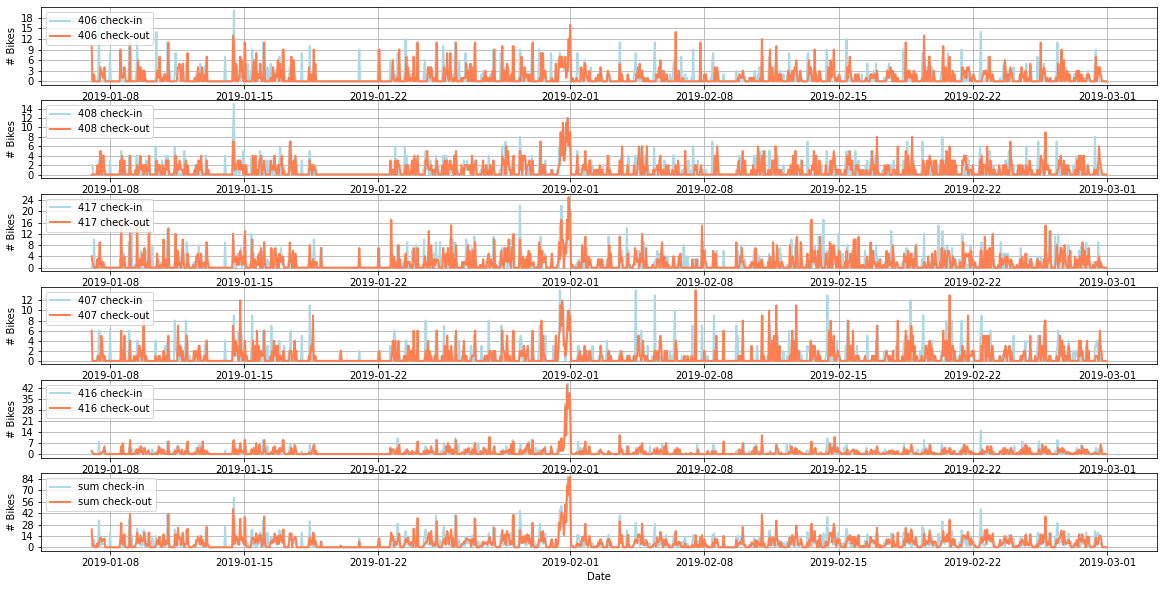

In [36]:
N = {'407': 17, '417': 23, '416': 16, '406': 17, '408': 10, 'sum': 83}
color = {'407': 'lightblue', '417': 'darkblue', '416': 'aquamarine', '406': 'coral', '408': 'teal',
            'sum': 'lightgreen'}
station = [407, 417, 416, 406, 408, 'sum']
cmap = ListedColormap(['lightblue', 'darkblue', 'aquamarine', 'coral', 'teal', 'lightgreen'], name='cmap',
                              N=None)

fig, axs = plt.subplots(nrows=6, figsize=(20, 10))
i = 0
for st in station:
    x = gira_df_with_extra_collums[i].index
    y = gira_df_with_extra_collums[i]['num_bicicletas_colocadas']
    z = gira_df_with_extra_collums[i]['num_bicicletas_retiradas']
    axs[i].plot(x, y, label=gira_df_with_extra_collums[i].name + ' check-in', color='lightblue', linewidth=2)
    axs[i].plot(x, z, label=gira_df_with_extra_collums[i].name + ' check-out', color='coral',
                        linewidth=2)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('# Bikes')
    axs[i].set_yticks(np.arange(0, max(max(z), max(y)), int(max(max(z), max(y)) / 6)))
    axs[i].grid()
    axs[i].legend(loc=2)
    i = i + 1
plt.show()
#fig.savefig('fev/delta60week.png')

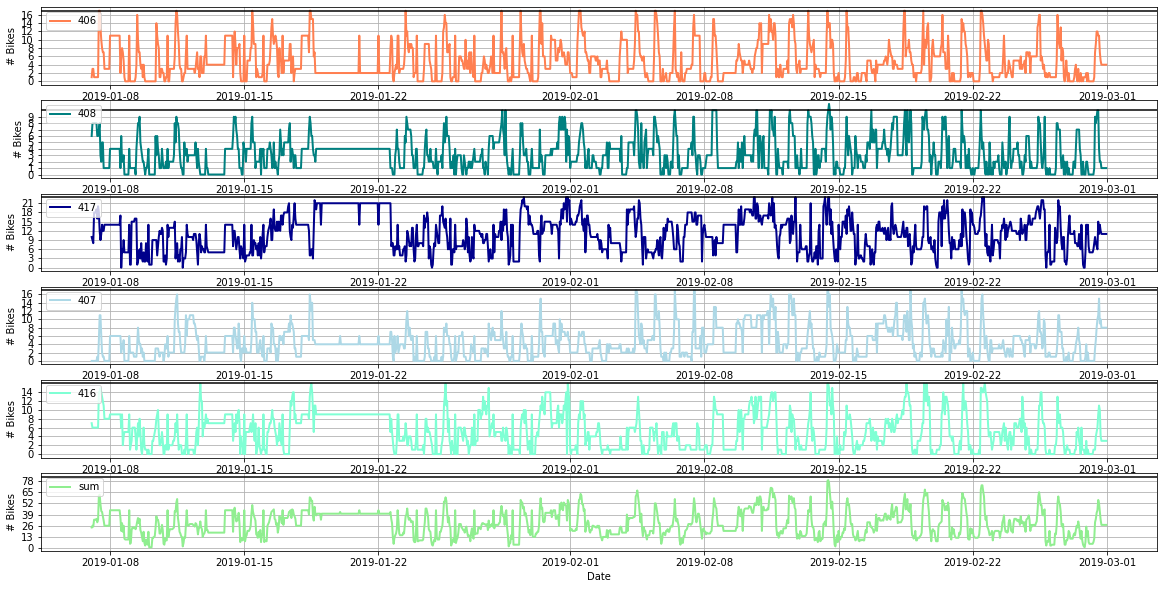

In [37]:
fig, axs = plt.subplots(nrows=6, figsize=(20, 10))
i = 0
for st in station:
    x = gira_df_with_extra_collums[i].index
    y = gira_df_with_extra_collums[i]['num_bicicletas']
    axs[i].plot(x, y, label=gira_df_with_extra_collums[i].name, color=color[gira_df_with_extra_collums[i].name],
                        linewidth=2)
    axs[i].axhline(y=N[gira_df_with_extra_collums[i].name], color='black')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('# Bikes')
    axs[i].set_yticks(
    np.arange(0, N[gira_df_with_extra_collums[i].name], int(N[gira_df_with_extra_collums[i].name] / 6)))
    axs[i].grid()
    axs[i].legend(loc=2)
    i = i + 1
plt.show()
#fig.savefig('fev/number60week.png')



<ipython-input-38-cb12f8ef315e>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


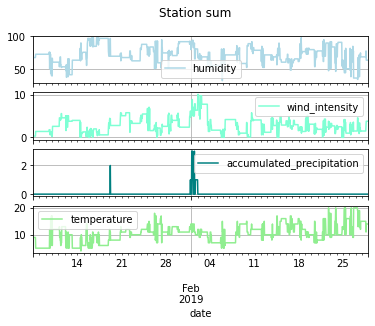

In [38]:
fig = meteo_df_min.plot(kind='line', subplots=True, sharex=True, sharey=False, use_index=True, \
                          title='Station ' + df.name, colormap=cmap, legend=True, grid=True)[0].get_figure()
fig.show()
#fig.savefig('fev/Station_' + df.name + '60week.png')

In [39]:
print(gira_df_with_extra_collums[0].name)
gira_df_with_extra_collums[0].describe()

406


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
count,1271.00000,1271.000000,1271.000000
mean,4.63808,1.113297,1.098348
std,4.39609,2.368708,2.248132
min,0.00000,0.000000,0.000000
25%,1.00000,0.000000,0.000000
50%,3.00000,0.000000,0.000000
75%,7.00000,1.000000,1.000000
max,17.00000,20.000000,16.000000


In [40]:
print(gira_df_with_extra_collums[1].name)
gira_df_with_extra_collums[1].describe()

408


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
count,1271.000000,1271.000000,1271.000000
mean,3.211644,0.917388,0.929976
std,2.611614,1.657796,1.583569
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,4.000000,1.000000,1.000000
max,11.000000,15.000000,12.000000


In [41]:
print(gira_df_with_extra_collums[2].name)
gira_df_with_extra_collums[2].describe()

417


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
count,1271.000000,1271.000000,1271.000000
mean,11.375295,1.690795,1.690008
std,5.842283,3.037752,3.014383
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,11.000000,0.000000,0.000000
75%,15.000000,2.000000,2.000000
max,23.000000,23.000000,25.000000


In [42]:
print(gira_df_with_extra_collums[3].name)
gira_df_with_extra_collums[3].describe()

407


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
count,1271.000000,1271.000000,1271.000000
mean,4.382376,0.864673,0.864673
std,3.743148,1.946271,1.842355
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,6.000000,1.000000,1.000000
max,17.000000,14.000000,14.000000


In [43]:
print(gira_df_with_extra_collums[4].name)
gira_df_with_extra_collums[4].describe()

416


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
count,1271.000000,1271.000000,1271.000000
mean,5.213218,1.158143,1.163651
std,4.101778,2.909286,2.990268
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,9.000000,1.000000,1.000000
max,16.000000,45.000000,44.000000


In [44]:
print(gira_df_with_extra_collums[5].name)
gira_df_with_extra_collums[5].describe()

sum


,num_bicicletas,num_bicicletas_colocadas,num_bicicletas_retiradas
count,1271.000000,1271.000000,1271.000000
mean,28.820614,5.744296,5.746656
std,14.971393,8.586562,8.620084
min,1.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000
50%,27.000000,3.000000,3.000000
75%,40.000000,8.000000,8.000000
max,79.000000,87.000000,87.000000


In [45]:
meteo_df_min.describe()

,humidity,wind_intensity,accumulated_precipitation,temperature
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,71.727773,2.832415,0.019670,10.563336
std,13.192154,1.765212,0.187205,3.329734
min,33.000000,0.000000,0.000000,4.000000
25%,63.000000,1.500000,0.000000,8.000000
50%,72.000000,2.600000,0.000000,11.000000
75%,80.000000,4.000000,0.000000,12.000000
max,98.000000,10.100000,3.000000,20.000000


Pearson (jan and feb)

In [46]:
def pearsoncorr(x,y):
    xmean=np.mean(x)
    ymean=np.mean(y)
    coef1=0
    coef2=0
    coef3=0
    for i in range(0,len(x)):
        coef1=coef1+(x[i]-xmean)*(y[i]-ymean)
        coef2=coef2+(x[i]-xmean)*(x[i]-xmean)
        coef3=coef3+(y[i]-ymean)*(y[i]-ymean)
    if coef2==0 or coef3==0:
        print('division by zero')
        return float('nan')
    return coef1/np.sqrt(coef2*coef3)

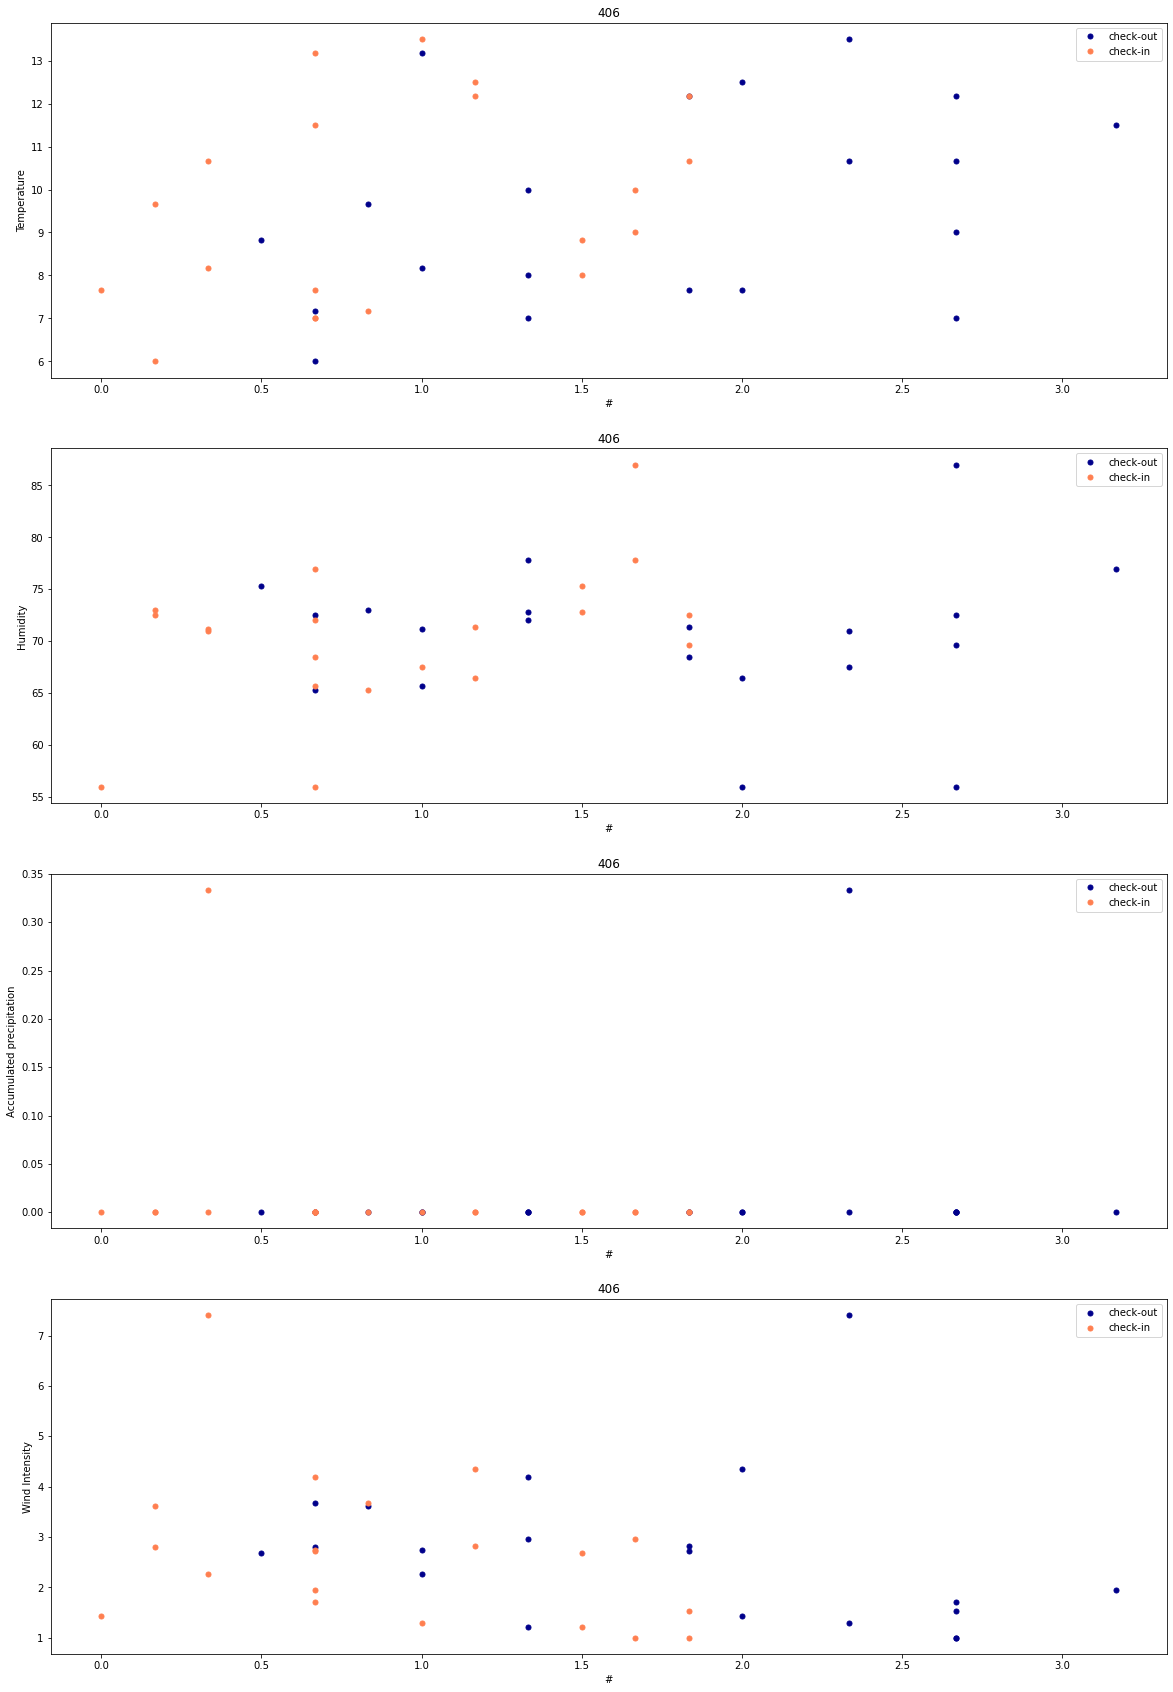

406
bikes, temp, prec, wind, hum 
n_bike, -0.09902353743457044,0.4522800446234433,0.18612838249666114,-0.01494474269994009
n_ret, 0.38436599236871843,0.17113601635481204,-0.2530906356133493,-0.004763204782051626
n_col, 0.33910982744327556,-0.23661277767063402,-0.3768278493642143,0.4521880471975597


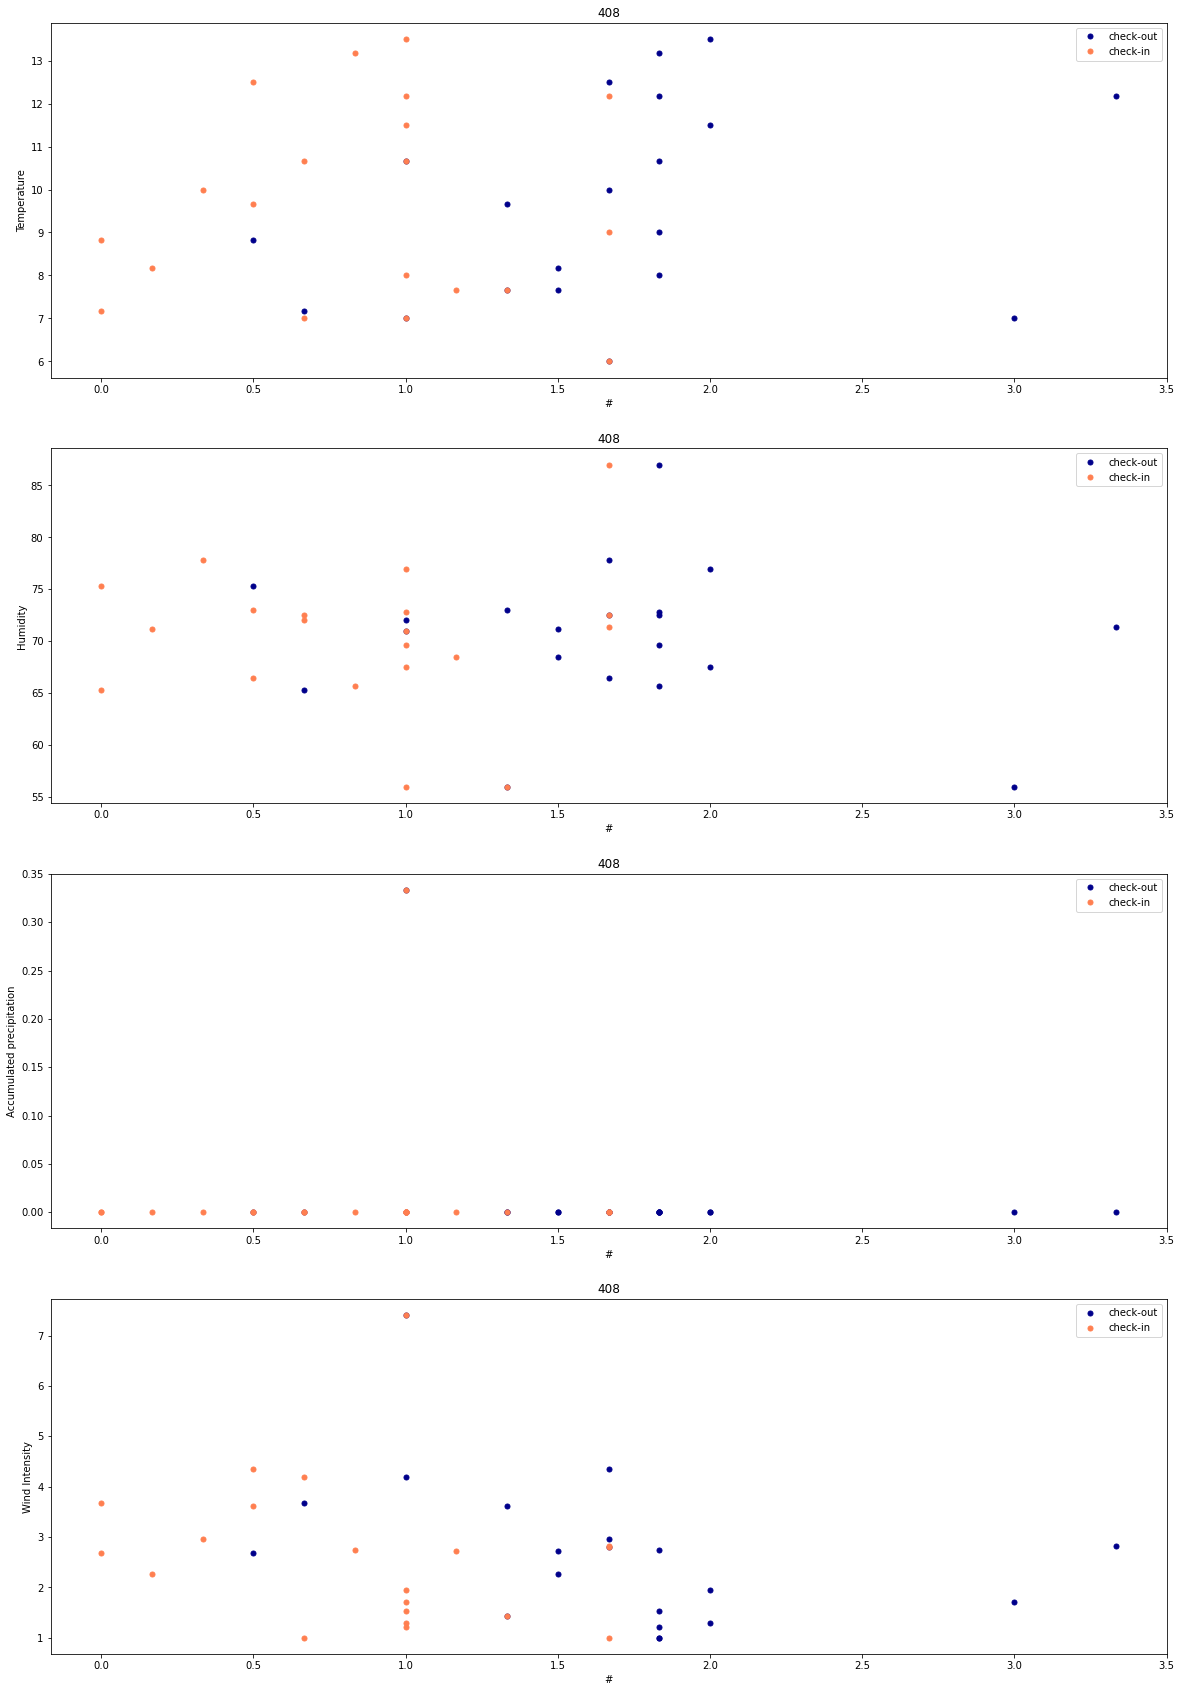

408
bikes, temp, prec, wind, hum 
n_bike, 0.02257323323004361,0.4669085076642934,0.24595450505409253,0.17869125289086454
n_ret, 0.3119895484323911,-0.23537557657892524,-0.4042345199739604,-0.13461063395935097
n_col, 0.02575379102666228,0.0652645271448546,-0.23679989025670892,0.04172603783735478


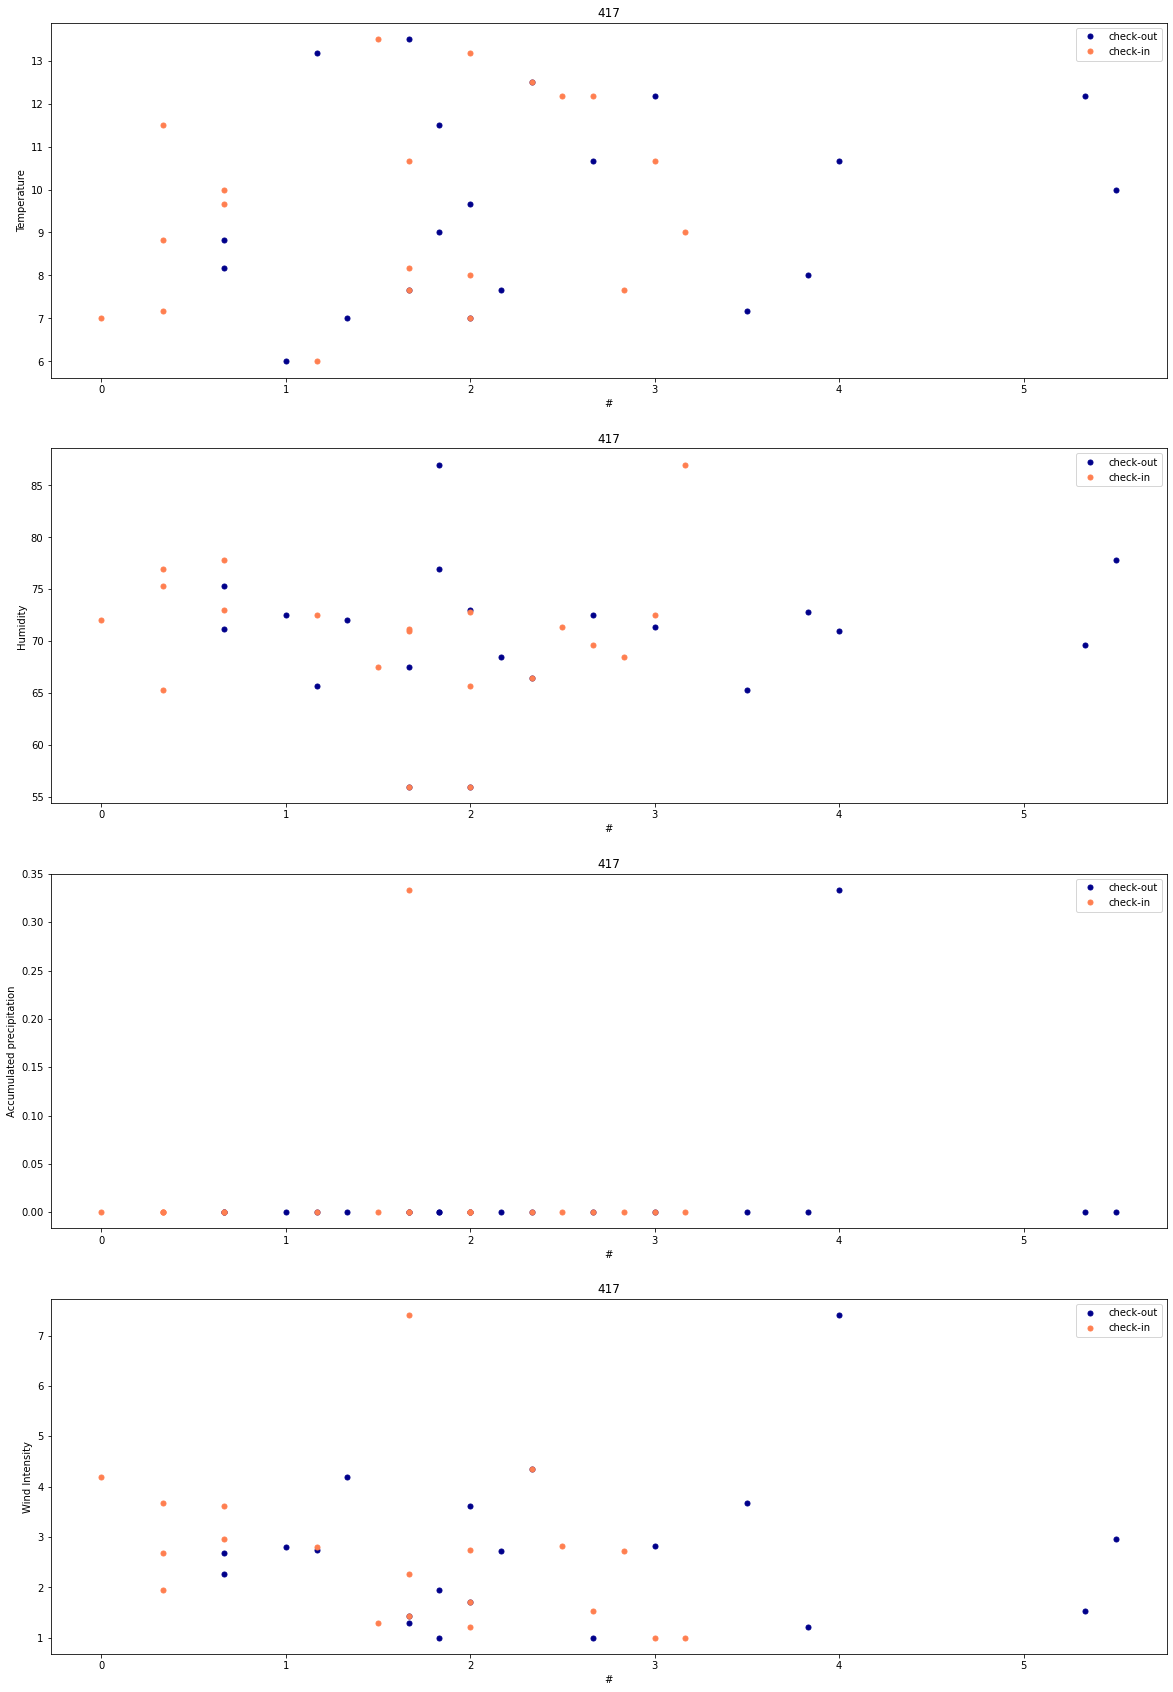

417
bikes, temp, prec, wind, hum 
n_bike, 0.03463308188130141,0.20769612112612967,0.17570679868590977,0.12055374682558878
n_ret, 0.22265034745043674,0.26776844044185505,0.1414757595738968,0.09298901980246467
n_col, 0.26731352070608616,0.01001633996207843,-0.3323311912425795,-0.0348539839776128


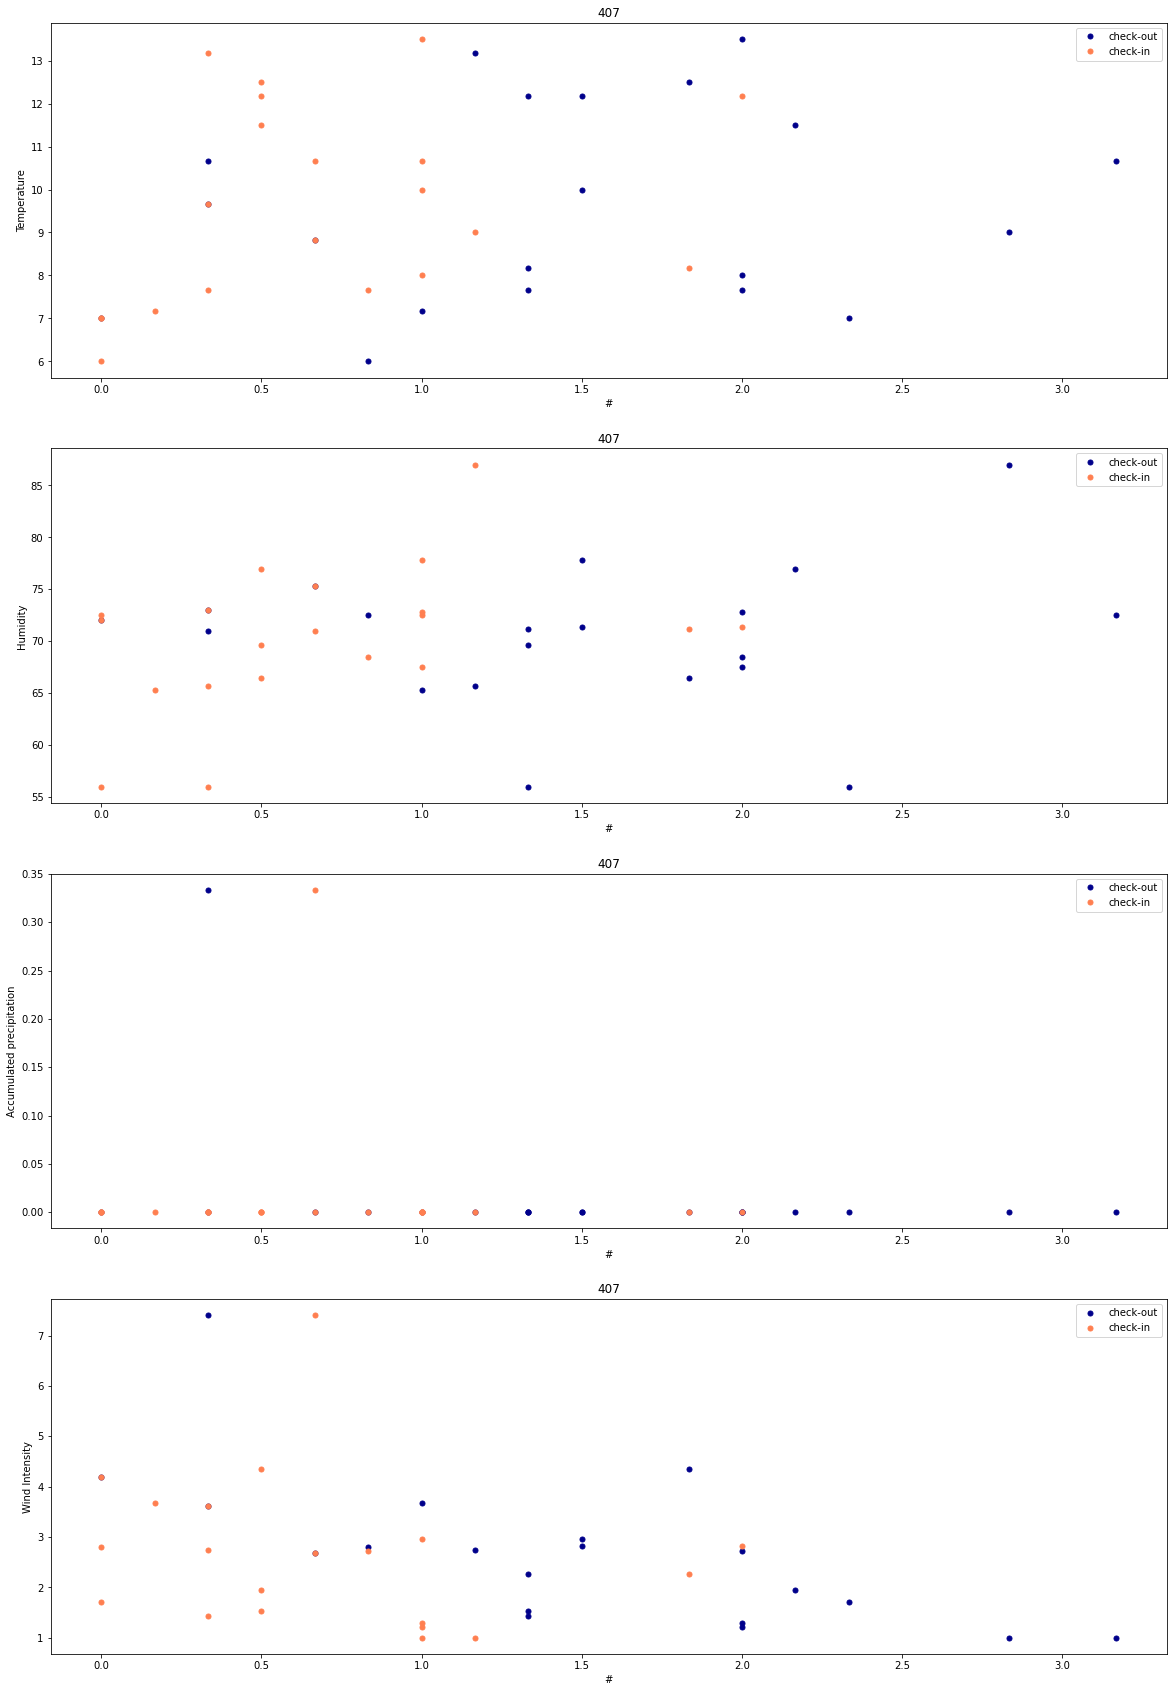

407
bikes, temp, prec, wind, hum 
n_bike, -0.13702871714867101,0.05787571507896615,0.20651349028097504,-0.008976298900100037
n_ret, 0.1927904014991803,-0.32591797989342824,-0.6780299845026455,0.09516788632064996
n_col, 0.3151671117934005,-0.0106060051467868,-0.2104064413132788,0.382423574512015


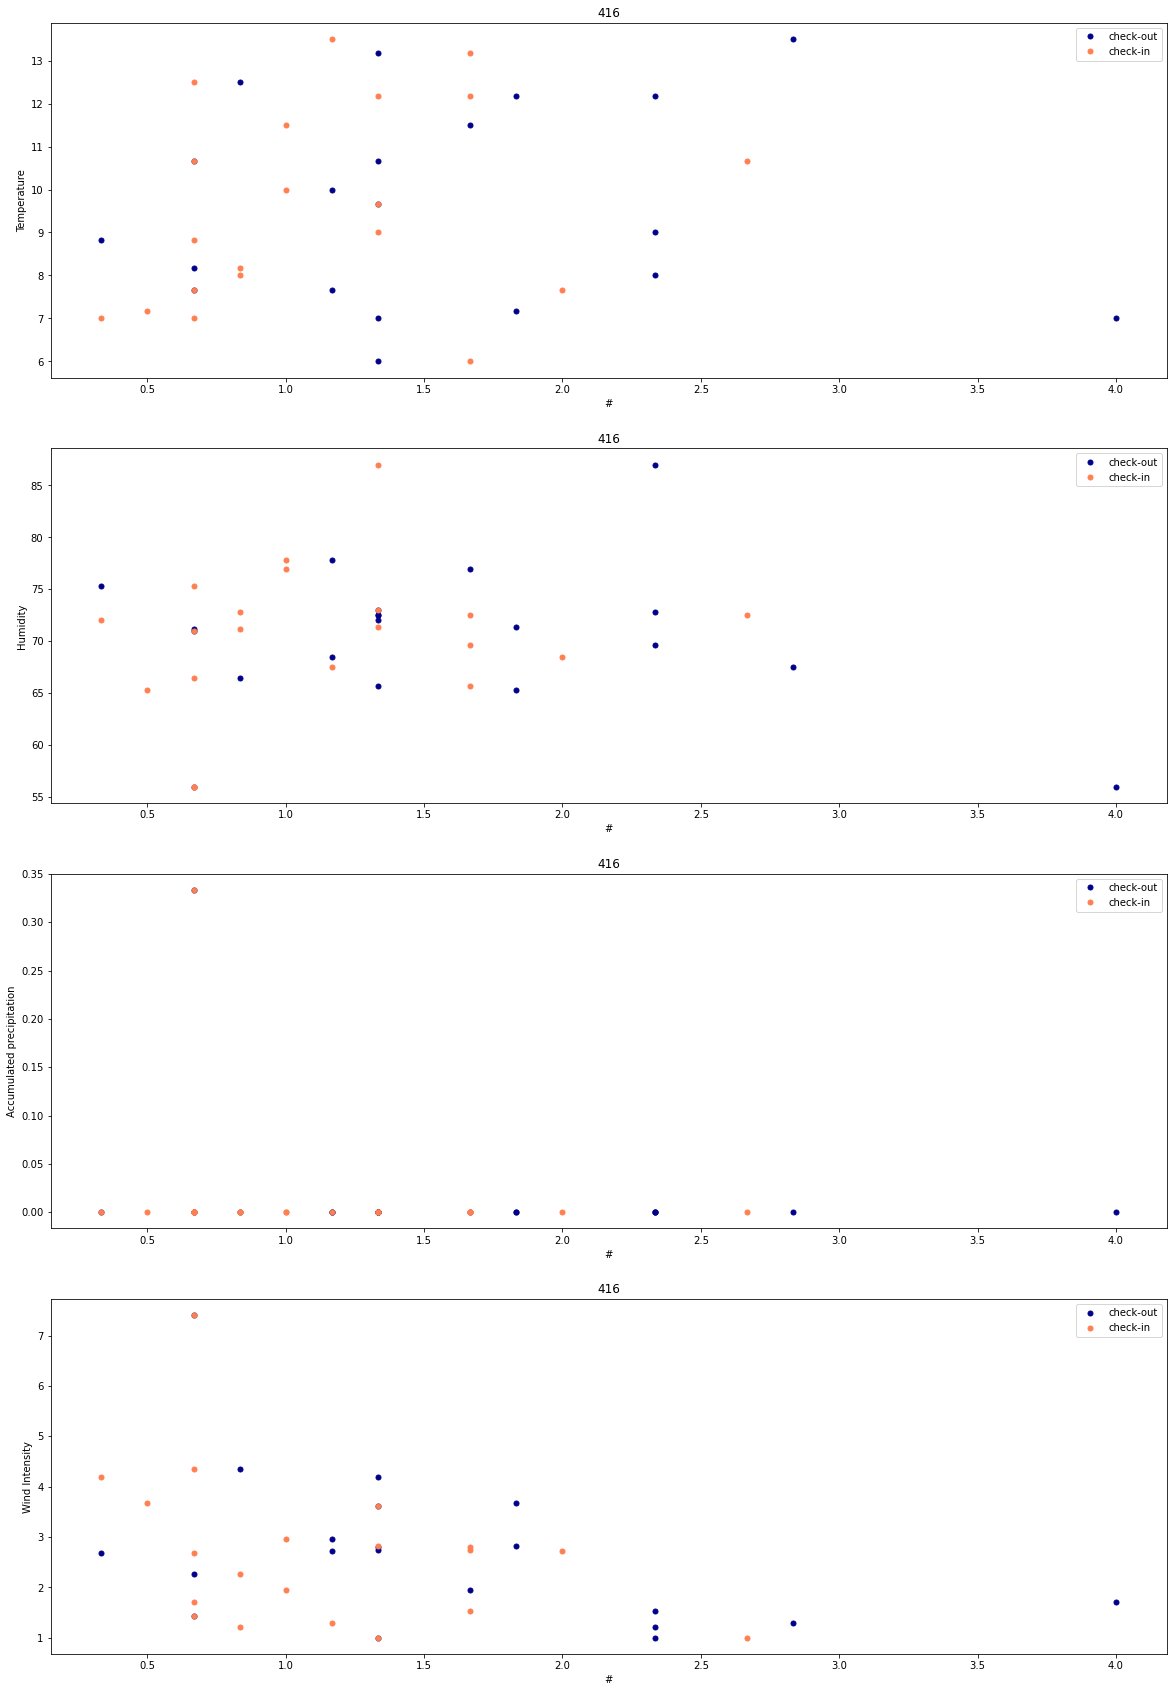

416
bikes, temp, prec, wind, hum 
n_bike, 0.07626836684612345,0.28925868321733533,0.1625013946302854,0.577681330350034
n_ret, 0.025386524495450945,-0.24230599967636124,-0.45812217224335205,-0.17079001698747362
n_col, 0.262860979152934,-0.18893060436399206,-0.38214928982774127,0.20196662668641185


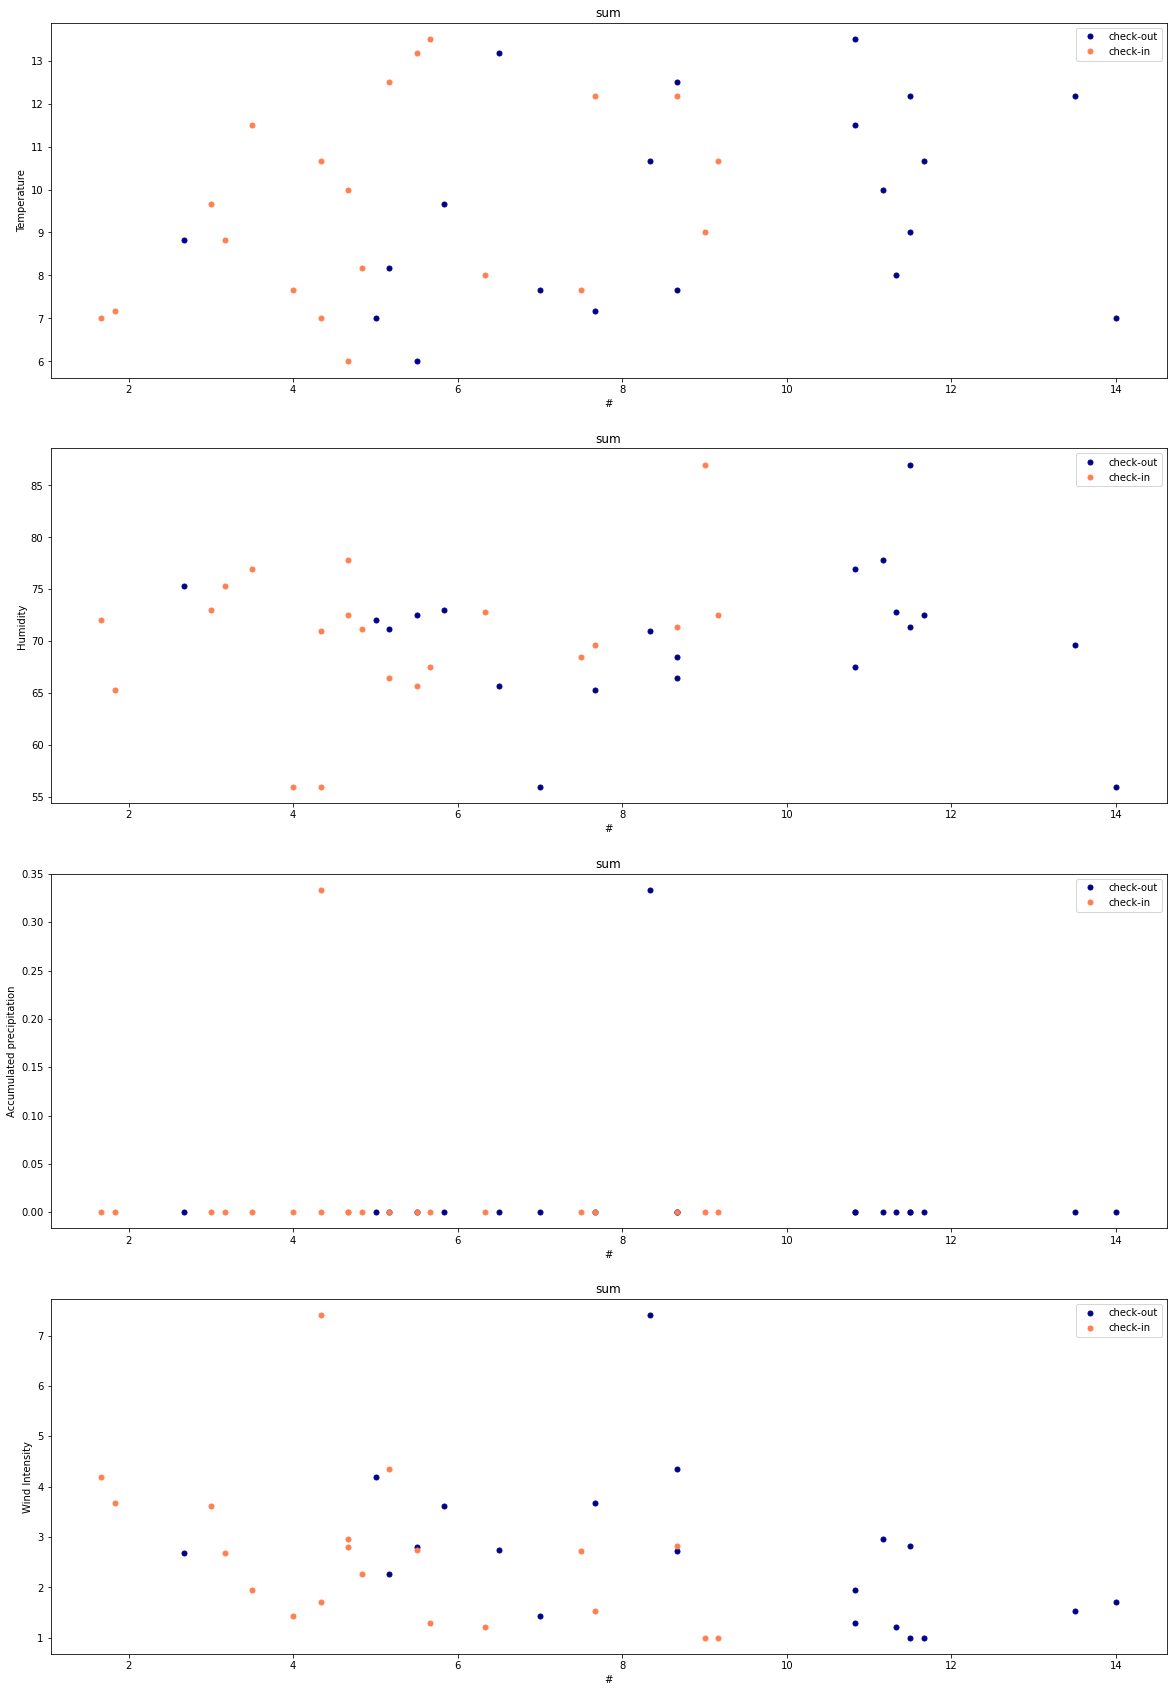

sum
bikes, temp, prec, wind, hum 
n_bike, -0.01890895980210824,0.45748789405624307,0.30859790653561997,0.2824594468406539
n_ret, 0.32328328930951505,-0.03999893754233205,-0.395465797354557,-0.010766417236995899
n_col, 0.3597517979720656,-0.09500389504406156,-0.45165218489270337,0.26143068770138955


In [47]:
corrtemp = dict()
corrhum = dict()
corrvento = dict()
corrpre=dict()
for df in gira_df_with_extra_collums:
    bike=[]
    ret=[]
    col=[]
    temp=[]
    prec=[]
    wind=[]
    hum=[]
    dayfev=[1,4,5,6,7,8,11,12,13,14,15,18,19,20,21,22,25,26,27,28]
    #dayjan=[1,2,3,4,7,8,10,11,15,16,17,18,23,24,25,28,29,30]
    #day=[[1,i] for i in dayjan]+[[2,i] for i in dayfev]
    day=[[2,i] for i in dayfev]
    for i in day:
        dateaux = datetime(year=2019, month=i[0], day=i[1])
        temp.append(np.mean(meteo_df_min.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['temperature'].values))
        #temp.append(np.mean(meteo_df_min.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['temperature'].values))
        prec.append(np.mean( meteo_df_min.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['accumulated_precipitation'].values))
        #prec.append(np.mean(meteo_df_min.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['accumulated_precipitation'].values))
        wind.append(np.mean(meteo_df_min.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['wind_intensity'].values))
        #wind.append(np.mean(meteo_df_min.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['wind_intensity'].values))
        hum.append(np.mean(meteo_df_min.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['humidity'].values))
        #hum.append(np.mean(meteo_df_min.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['humidity'].values))
        bike.append(np.mean(df.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['num_bicicletas'].values))
        #bike.append(np.mean(df.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['num_bicicletas'].values))
        ret.append(np.mean(df.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['num_bicicletas_retiradas'].values))
        #ret.append(np.mean(df.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['num_bicicletas_retiradas'].values))
        col.append(np.mean(df.loc[(df.index.hour <= 16) & (df.index.hour >= 14) & (df.index.day == dateaux.day)]['num_bicicletas_colocadas'].values))
        #col.append(np.mean(df.loc[(df.index.hour <= 13) & (df.index.hour >= 11) & (df.index.day == dateaux.day)]['num_bicicletas_colocadas'].values))

    corrtemp[df.name]=[pearsoncorr(bike,temp),pearsoncorr(ret,temp),pearsoncorr(col,temp)]
    corrvento[df.name] = [pearsoncorr(bike, wind), pearsoncorr(ret, wind), pearsoncorr(col, wind)]
    corrhum[df.name] = [pearsoncorr(bike, hum), pearsoncorr(ret, hum), pearsoncorr(col, hum)]
    corrpre[df.name] = [pearsoncorr(bike, prec), pearsoncorr(ret, prec), pearsoncorr(col, prec)]

    fig, axs = plt.subplots(nrows=4, figsize=(20, 30))
    #axs[0].plot(bike,temp,'.',markersize=5 ,color='teal',label='Bike')
    axs[0].plot(ret, temp,'.',markersize=10 , color='darkblue', label='check-out')
    axs[0].plot(col, temp,'.',markersize=10, color='coral', label='check-in')
    axs[0].legend()
    axs[0].set_xlabel('#')
    axs[0].set_ylabel('Temperature')
    axs[0].set_title(df.name)
    #axs[1].plot(bike, hum,'.',markersize=5 , color='teal', label='Bike')
    axs[1].plot(ret, hum,'.',markersize=10 , color='darkblue', label='check-out')
    axs[1].plot(col, hum,'.',markersize=10 , color='coral', label='check-in')
    axs[1].legend()
    axs[1].set_xlabel('#')
    axs[1].set_ylabel('Humidity')
    axs[1].set_title(df.name)
    #axs[2].plot(bike, prec,'.',markersize=5 , color='teal', label='Bike')
    axs[2].plot(ret, prec,'.',markersize=10 , color='darkblue', label='check-out')
    axs[2].plot(col, prec,'.',markersize=10 , color='coral', label='check-in')
    axs[2].legend()
    axs[2].set_xlabel('#')
    axs[2].set_ylabel('Accumulated precipitation')
    axs[2].set_title(df.name)
    #axs[3].plot(bike, wind,'.',markersize=5 , color='teal', label='Bike')
    axs[3].plot(ret, wind,'.',markersize=10, color='darkblue', label='check-out')
    axs[3].plot(col, wind,'.',markersize=10 , color='coral', label='check-in')
    axs[3].legend()
    axs[3].set_xlabel('#')
    axs[3].set_ylabel('Wind Intensity')
    axs[3].set_title(df.name)
    #fig.savefig('fev/'+df.name+'plots601416.png')
    plt.show()
    
    print(df.name)
    print('bikes, temp, prec, wind, hum ')
    print('n_bike, {},{},{},{}'.format(corrtemp[df.name][0],corrpre[df.name][0],corrvento[df.name][0],corrhum[df.name][0]))
    print('n_ret, {},{},{},{}'.format(corrtemp[df.name][1], corrpre[df.name][1], corrvento[df.name][1],
                                               corrhum[df.name][1]))
    print('n_col, {},{},{},{}'.format(corrtemp[df.name][2], corrpre[df.name][2], corrvento[df.name][2],
                                               corrhum[df.name][2]))

DCCA analysis (only february)

In [20]:
def recta(x,A,B):
    return A*x+B

def Regression(list):
    listt = [ii for ii in range(0, len(list))]
    par, cov = opt.curve_fit(xdata=listt, ydata=list, f=recta)
    listy = [recta(t, par[0], par[1]) for t in listt]
    return listy

def X(list):
    aux = 0
    mean=np.mean(list)
    listr=[]
    for iter in range(0, len(list)):
        aux = (list[iter]-mean) + aux
        listr.append(aux)
    return listr


def f_DCCA_squared(list1, list2, leng, box):
    aux = 0
    #print(list1)
    listaux1 = list1[box:box + leng]
    #print(listaux1)
    listaux2 = list2[box:box + leng]
    listreg1 = Regression(listaux1)
    listreg2 = Regression(listaux2)
    for iter in range(0, leng):
        aux1 = listaux1[iter]-listreg1[iter]
        aux2 = listaux2[iter]-listreg2[iter]
        aux = aux + aux1 * aux2
    aux = aux / (leng)
    return aux


def F_DCCA_squared(list1, list2, leng):
    N = len(list1)
    aux = 0
    for iter in range(0, N - leng):
        aux1 = f_DCCA_squared(list1, list2, leng, iter)
        aux = aux + aux1
    aux = aux / (N - leng)
    return aux


def DCCA_coeff(list1, list2, leng):
    F11 = F_DCCA_squared(list1, list1, leng)
    F22 = F_DCCA_squared(list2, list2, leng)
    F12 = F_DCCA_squared(list1, list2, leng)
    return F12 / np.sqrt(F11 * F22)

In [21]:
temperatura = meteo_df_min['temperature'].values
humiddade = meteo_df_min['humidity'].values
vento = meteo_df_min['wind_intensity'].values
prec=meteo_df_min['accumulated_precipitation'].values
n = np.geomspace(start=5, stop=int(len(temperatura)*2/3), num=30,dtype=int)
sigmatemp = []
sigmawind=[]
sigmahum=[]
sigmapre=[]
number_bike = gira_df_with_extra_collums[-1]['num_bicicletas'].values
number_ret = gira_df_with_extra_collums[-1]['num_bicicletas_retiradas'].values
number_col = gira_df_with_extra_collums[-1]['num_bicicletas_colocadas'].values
Xnumber_ret=X(number_ret)
Xnumber_col = X(number_col)
Xvento = X(vento)
Xhum=X(humiddade)
Xprec=X(prec)
Xtemp=X(temperatura)

In [22]:
for i in n:
    sigmaw = DCCA_coeff(Xnumber_col,Xvento , i)
    sigmawind.append(sigmaw)
    sigmat = DCCA_coeff(Xnumber_col, Xtemp, i)
    sigmatemp.append(sigmat)
    sigmah = DCCA_coeff(Xnumber_col, Xhum, i)
    sigmahum.append(sigmah)
    sigmap = DCCA_coeff(Xnumber_col, Xprec, i)
    sigmapre.append(sigmap)

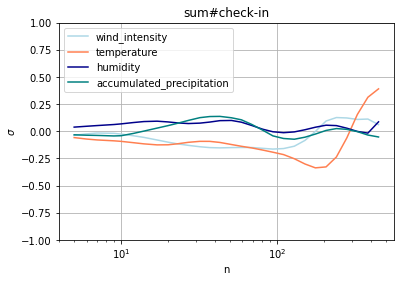

In [23]:
fig=plt.figure()
plt.plot(n, sigmawind, label='wind_intensity',color='lightblue')
plt.plot(n, sigmatemp, label='temperature',color='coral')
plt.plot(n, sigmahum, label='humidity',color='darkblue')
plt.plot(n, sigmapre, label='accumulated_precipitation',color='teal')
plt.xlabel('n')
plt.ylim(-1,1)
plt.ylabel('$\sigma$')
plt.grid()
plt.title(gira_df_with_extra_collums[-1].name+'#check-in')
plt.xscale('log')
plt.legend()
plt.show()
#plt.savefig('fev/sigmaret.png',bbox_inches='tight')

DCCAl analysis only february

In [24]:
def Preg(list, l):
    listt = [ii for ii in range(0, len(list))]
    p = np.polyfit(x=listt, y=list, deg=l)
    pol = np.poly1d(p)
    listy = [pol(t) for t in listt]
    return listy

def X(list):
    aux = 0
    mean = np.mean(list)
    listr = []
    for iter in range(0, len(list)):
        aux = (list[iter] - mean) + aux
        listr.append(aux)
    return listr

def f_DCCA_squared_pol(list1, list2, leng, box, l):
    aux = 0
    listaux1 = list1[box:box + leng]
    listaux2 = list2[box:box + leng]
    listreg1 = Preg(listaux1,l)
    listreg2 = Preg(listaux2,l)
    for iter in range(0, leng):
        aux1 = listaux1[iter] - listreg1[iter]
        aux2 = listaux2[iter] - listreg2[iter]
        aux = aux + aux1 * aux2
    aux = aux / (leng)
    return aux

def F_DCCA_squared_pol(list1, list2, leng, l):
    N = len(list1)
    aux = 0
    for iter in range(0, N - leng):
        aux1 = f_DCCA_squared_pol(list1, list2, leng, iter, l)
        aux = aux + aux1
    aux = aux / (N - leng)
    return aux

def DCCA_coeff_pol(list1, list2, leng):
    if leng<=4:
        l=1
    if leng<=6 and leng>4:
        l=2
    if leng<=10 and leng>6:
        l=4
    if leng<=18 and leng>10:
        l=8
    if leng>18:
        l=16
    #l=int(16*leng/len(list1))
    F11 = F_DCCA_squared_pol(list1, list1, leng,l)
    F22 = F_DCCA_squared_pol(list2, list2, leng,l)
    F12 = F_DCCA_squared_pol(list1, list2, leng,l)
    return F12 / np.sqrt(F11 * F22)


In [25]:
temperatura = meteo_df_min['temperature'].values
humiddade = meteo_df_min['humidity'].values
vento = meteo_df_min['wind_intensity'].values
prec = meteo_df_min['accumulated_precipitation'].values
n = np.geomspace(start=5, stop=int(len(temperatura)*2/3), num=20, dtype=int)
sigmatemp = []
sigmawind = []
sigmahum = []
sigmapre = []
number_bike = gira_df_with_extra_collums[-1]['num_bicicletas'].values
number_ret = gira_df_with_extra_collums[-1]['num_bicicletas_retiradas'].values
number_col = gira_df_with_extra_collums[-1]['num_bicicletas_colocadas'].values
Xn_col=X(number_col)
Xn_ret=X(number_ret)
Xtemp=X(temperatura)
Xhum=X(humiddade)
Xvento=X(vento)
Xprec=X(prec)

In [26]:
for i in n:
    sigmaw = DCCA_coeff_pol(Xn_ret, Xvento, i)
    sigmawind.append(sigmaw)
    sigmat = DCCA_coeff_pol(Xn_ret, Xtemp, i)
    sigmatemp.append(sigmat)
    sigmah = DCCA_coeff_pol(Xn_ret, Xhum, i)
    sigmahum.append(sigmah)
    sigmap = DCCA_coeff_pol(Xn_ret, Xprec, i)
    sigmapre.append(sigmap)

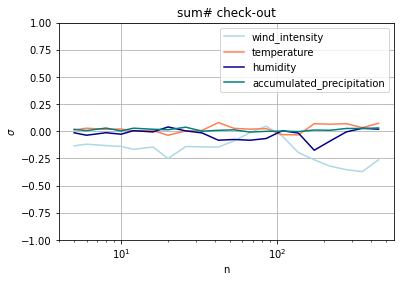

In [27]:
fig = plt.figure()
plt.plot(n, sigmawind, label='wind_intensity', color='lightblue')
plt.plot(n, sigmatemp, label='temperature', color='coral')
plt.plot(n, sigmahum, label='humidity', color='darkblue')
plt.plot(n, sigmapre, label='accumulated_precipitation', color='teal')
plt.xlabel('n')
plt.ylim(-1, 1)
plt.ylabel('$\sigma$')
plt.grid()
plt.title(gira_df_with_extra_collums[-1].name + '# check-out')
plt.xscale('log')
plt.legend()
plt.show()
#plt.savefig('1-2-28-2/sigmabike.png', bbox_inches='tight')